```
Licensed to the Apache Software Foundation (ASF) under one
or more contributor license agreements.  See the NOTICE file
distributed with this work for additional information
regarding copyright ownership.  The ASF licenses this file
to you under the Apache License, Version 2.0 (the
"License"); you may not use this file except in compliance
with the License.  You may obtain a copy of the License at
  http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing,
software distributed under the License is distributed on an
"AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
KIND, either express or implied.  See the License for the
specific language governing permissions and limitations
under the License.
```

In [1]:
from IPython.display import display, HTML
from pyspark.sql import SparkSession
from pyspark import StorageLevel
import pandas as pd
from pyspark.sql.types import StructType, StructField,StringType, LongType, IntegerType, DoubleType, ArrayType
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import col, split, expr
from pyspark.sql.functions import udf, lit
from sedona.spark import *
from pyspark.sql.functions import col, split, expr
from pyspark.sql.functions import udf, lit
import os


# Create Spark Session for application

In [2]:
config = SedonaContext.builder() .\
    config('spark.jars.packages',
           'org.apache.sedona:sedona-spark-shaded-3.0_2.12:1.4.1,'
           'org.datasyslab:geotools-wrapper:1.4.0-28.2'). \
    getOrCreate()

sedona = SedonaContext.create(config)

sc = sedona.sparkContext


:: loading settings :: url = jar:file:/Users/nileshgajwani/Desktop/spark/spark-3.4.0-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/nileshgajwani/.ivy2/cache
The jars for the packages stored in: /Users/nileshgajwani/.ivy2/jars
org.apache.sedona#sedona-spark-shaded-3.0_2.12 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-f6cc1c05-35e7-48b0-8060-745906834ca0;1.0
	confs: [default]
	found org.apache.sedona#sedona-spark-shaded-3.0_2.12;1.4.1 in central
	found org.datasyslab#geotools-wrapper;1.4.0-28.2 in central
:: resolution report :: resolve 79ms :: artifacts dl 2ms
	:: modules in use:
	org.apache.sedona#sedona-spark-shaded-3.0_2.12;1.4.1 from central in [default]
	org.datasyslab#geotools-wrapper;1.4.0-28.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------

# Geotiff Loader 

1. Loader takes as input a path to directory which contains geotiff files or a path to particular geotiff file
2. Loader will read geotiff image in a struct named image which contains multiple fields as shown in the schema below which can be extracted using spark SQL

In [3]:
# Path to directory of geotiff images 
DATA_DIR = "./data/raster/"

In [5]:
df = sedona.read.format("geotiff").option("dropInvalid",True).option("readToCRS", "EPSG:4326").option("disableErrorInCRS", False).load(DATA_DIR)
df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- geometry: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nBands: integer (nullable = true)
 |    |-- data: array (nullable = true)
 |    |    |-- element: double (containsNull = true)



In [6]:
df = df.selectExpr("image.origin as origin","ST_GeomFromWkt(image.geometry) as Geom", "image.height as height", "image.width as width", "image.data as data", "image.nBands as bands")
df.show(5)

+--------------------+--------------------+------+-----+--------------------+-----+
|              origin|                Geom|height|width|                data|bands|
+--------------------+--------------------+------+-----+--------------------+-----+
|file:/Users/niles...|POLYGON ((-58.702...|    32|   32|[1081.0, 1068.0, ...|    4|
|file:/Users/niles...|POLYGON ((-58.286...|    32|   32|[1151.0, 1141.0, ...|    4|
+--------------------+--------------------+------+-----+--------------------+-----+



# Extract a particular band from geotiff dataframe using RS_GetBand()


In [7]:
'''RS_GetBand() will fetch a particular band from given data array which is the concatenation of all the bands'''

df = df.selectExpr("Geom","RS_GetBand(data, 1,bands) as Band1","RS_GetBand(data, 2,bands) as Band2","RS_GetBand(data, 3,bands) as Band3", "RS_GetBand(data, 4,bands) as Band4")
df.createOrReplaceTempView("allbands")
df.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                Geom|               Band1|               Band2|               Band3|               Band4|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|POLYGON ((-58.702...|[1081.0, 1068.0, ...|[909.0, 909.0, 82...|[677.0, 660.0, 66...|[654.0, 652.0, 66...|
|POLYGON ((-58.286...|[1151.0, 1141.0, ...|[894.0, 956.0, 10...|[751.0, 802.0, 87...|[0.0, 0.0, 0.0, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+



# Map Algebra operations on band values

In [8]:
'''RS_NormalizedDifference can be used to calculate NDVI for a particular geotiff image since it uses same computational formula as ndvi'''

NomalizedDifference = df.selectExpr("RS_NormalizedDifference(Band1, Band2) as normDiff")
NomalizedDifference.show(5)

+--------------------+
|            normDiff|
+--------------------+
|[-0.09, -0.08, -0...|
|[-0.13, -0.09, -0...|
+--------------------+



In [9]:
'''RS_Mean() can used to calculate mean of piel values in a particular spatial band'''
meanDF = df.selectExpr("RS_Mean(Band1) as mean")
meanDF.show(5)

+-------+
|   mean|
+-------+
|1153.85|
|1293.77|
+-------+



In [10]:
""" RS_Mode() is used to calculate mode in an array of pixels and returns a array of double with size 1 in case of unique mode"""
modeDF = df.selectExpr("RS_Mode(Band1) as mode")
modeDF.show(5)

+----------------+
|            mode|
+----------------+
| [1011.0, 927.0]|
|[1176.0, 1230.0]|
+----------------+



In [11]:
'''RS_GreaterThan() is used to mask all the values with 1 which are greater than a particular threshold'''
greaterthanDF = sedona.sql("Select RS_GreaterThan(Band1,1000.0) as greaterthan from allbands")
greaterthanDF.show()

+--------------------+
|         greaterthan|
+--------------------+
|[1.0, 1.0, 1.0, 0...|
|[1.0, 1.0, 1.0, 1...|
+--------------------+



In [12]:
'''RS_GreaterThanEqual() is used to mask all the values with 1 which are greater than a particular threshold'''

greaterthanEqualDF = sedona.sql("Select RS_GreaterThanEqual(Band1,360.0) as greaterthanEqual from allbands")
greaterthanEqualDF.show()

+--------------------+
|    greaterthanEqual|
+--------------------+
|[1.0, 1.0, 1.0, 1...|
|[1.0, 1.0, 1.0, 1...|
+--------------------+



In [14]:
'''RS_LessThan() is used to mask all the values with 1 which are less than a particular threshold'''
lessthanDF = sedona.sql("Select RS_LessThan(Band1,1000.0) as lessthan from allbands")
lessthanDF.show()

+--------------------+
|            lessthan|
+--------------------+
|[0.0, 0.0, 0.0, 1...|
|[0.0, 0.0, 0.0, 0...|
+--------------------+



In [15]:
'''RS_LessThanEqual() is used to mask all the values with 1 which are less than equal to a particular threshold'''
lessthanEqualDF = sedona.sql("Select RS_LessThanEqual(Band1,2890.0) as lessthanequal from allbands")
lessthanEqualDF.show()

+--------------------+
|       lessthanequal|
+--------------------+
|[1.0, 1.0, 1.0, 1...|
|[1.0, 1.0, 1.0, 1...|
+--------------------+



In [16]:
'''RS_Add() can add two spatial bands together'''
sumDF = df.selectExpr("RS_Add(Band1, Band2) as sumOfBand")
sumDF.show(5)

+--------------------+
|           sumOfBand|
+--------------------+
|[1990.0, 1977.0, ...|
|[2045.0, 2097.0, ...|
+--------------------+



In [17]:
'''RS_Subtract() can subtract two spatial bands together'''
subtractDF = df.selectExpr("RS_Subtract(Band1, Band2) as diffOfBand")
subtractDF.show(5)

+--------------------+
|          diffOfBand|
+--------------------+
|[-172.0, -159.0, ...|
|[-257.0, -185.0, ...|
+--------------------+



In [18]:
'''RS_Multiply() can multiple two bands together'''
multiplyDF = df.selectExpr("RS_Multiply(Band1, Band2) as productOfBand")
multiplyDF.show(5)

+--------------------+
|       productOfBand|
+--------------------+
|[982629.0, 970812...|
|[1028994.0, 10907...|
+--------------------+



In [19]:
'''RS_Divide() can divide two bands together'''
divideDF = df.selectExpr("RS_Divide(Band1, Band2) as divisionOfBand")
divideDF.show(5)

+--------------------+
|      divisionOfBand|
+--------------------+
|[1.19, 1.17, 1.25...|
|[1.29, 1.19, 1.19...|
+--------------------+



In [20]:
'''RS_MultiplyFactor() will multiply a factor to a spatial band'''
mulfacDF = df.selectExpr("RS_MultiplyFactor(Band2, 2) as target")
mulfacDF.show(5)

+--------------------+
|              target|
+--------------------+
|[1818.0, 1818.0, ...|
|[1788.0, 1912.0, ...|
+--------------------+



In [21]:
'''RS_BitwiseAND() will return AND between two values of Bands'''
bitwiseAND = df.selectExpr("RS_BitwiseAND(Band1, Band2) as AND")
bitwiseAND.show(5)

+--------------------+
|                 AND|
+--------------------+
|[9.0, 12.0, 2.0, ...|
|[126.0, 52.0, 102...|
+--------------------+



In [22]:
'''RS_BitwiseOR() will return OR between two values of Bands'''
bitwiseOR = df.selectExpr("RS_BitwiseOR(Band1, Band2) as OR")
bitwiseOR.show(5)

+--------------------+
|                  OR|
+--------------------+
|[1981.0, 1965.0, ...|
|[1919.0, 2045.0, ...|
+--------------------+



In [23]:
'''RS_Count() will calculate the total number of occurrence of a target value'''
countDF = df.selectExpr("RS_Count(RS_GreaterThan(Band1,1000.0), 1.0) as count")
countDF.show(5)

+-----+
|count|
+-----+
|  753|
| 1017|
+-----+



In [24]:
'''RS_Modulo() will calculate the modulus of band value with respect to a given number'''
moduloDF = df.selectExpr("RS_Modulo(Band1, 21.0) as modulo ")
moduloDF.show(5)

+--------------------+
|              modulo|
+--------------------+
|[10.0, 18.0, 18.0...|
|[17.0, 7.0, 2.0, ...|
+--------------------+



In [25]:
'''RS_SquareRoot() will calculate calculate square root of all the band values up to two decimal places'''
rootDF = df.selectExpr("RS_SquareRoot(Band1) as root")
rootDF.show(5)


+--------------------+
|                root|
+--------------------+
|[32.88, 32.68, 32...|
|[33.93, 33.78, 35...|
+--------------------+



In [26]:
'''RS_LogicalDifference() will return value from band1 if value at that particular location is not equal tp band1 else it will return 0'''
logDiff = df.selectExpr("RS_LogicalDifference(Band1, Band2) as loggDifference")
logDiff.show(5)

+--------------------+
|      loggDifference|
+--------------------+
|[1081.0, 1068.0, ...|
|[1151.0, 1141.0, ...|
+--------------------+



In [27]:
'''RS_LogicalOver() will iterate over two bands and return value of first band if it is not equal to 0 else it will return value from later band'''
logOver = df.selectExpr("RS_LogicalOver(Band3, Band2) as logicalOver")
logOver.show(5)

+--------------------+
|         logicalOver|
+--------------------+
|[677.0, 660.0, 66...|
|[751.0, 802.0, 87...|
+--------------------+



# Visualising Geotiff Images

1. Normalize the bands in range [0-255] if values are greater than 255
2. Process image using RS_Base64() which converts in into a base64 string
3. Embed results of RS_Base64() in RS_HTML() to embed into IPython notebook
4. Process results of RS_HTML() as below:

In [29]:
'''Plotting images as a dataframe using geotiff Dataframe.'''

df = sedona.read.format("geotiff").option("dropInvalid",True).option("readToCRS", "EPSG:4326").load(DATA_DIR)
df = df.selectExpr("image.origin as origin","ST_GeomFromWkt(image.geometry) as Geom", "image.height as height", "image.width as width", "image.data as data", "image.nBands as bands")

df = df.selectExpr("RS_GetBand(data,1,bands) as targetband", "height", "width", "bands", "Geom")
df_base64 = df.selectExpr("Geom", "RS_Base64(height,width,RS_Normalize(targetBand), RS_Array(height*width,0.0), RS_Array(height*width, 0.0)) as red","RS_Base64(height,width,RS_Array(height*width, 0.0), RS_Normalize(targetBand), RS_Array(height*width, 0.0)) as green", "RS_Base64(height,width,RS_Array(height*width, 0.0),  RS_Array(height*width, 0.0), RS_Normalize(targetBand)) as blue","RS_Base64(height,width,RS_Normalize(targetBand), RS_Normalize(targetBand),RS_Normalize(targetBand)) as RGB" )
df_HTML = df_base64.selectExpr("Geom","RS_HTML(red) as RedBand","RS_HTML(blue) as BlueBand","RS_HTML(green) as GreenBand", "RS_HTML(RGB) as CombinedBand")
df_HTML.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                Geom|             RedBand|            BlueBand|           GreenBand|        CombinedBand|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|POLYGON ((-58.702...|<img src="data:im...|<img src="data:im...|<img src="data:im...|<img src="data:im...|
|POLYGON ((-58.286...|<img src="data:im...|<img src="data:im...|<img src="data:im...|<img src="data:im...|
+--------------------+--------------------+--------------------+--------------------+--------------------+



,Geom,RedBand,BlueBand,GreenBand,CombinedBand
0,"POLYGON ((-58.70271939504447 -34.418775445554786, -58.702776058228636 -34.421569880680615, -58.6994039180242 -34.42161679331493, -58.69934736692278 -34.4188223533111, -58.70271939504447 -34.418775445554786))",,,,
1,"POLYGON ((-58.286636576261145 -34.758580906202866, -58.286679941749476 -34.76137571668496, -58.28329340123003 -34.76141146033393, -58.28325014980317 -34.75861664615162, -58.286636576261145 -34.758580906202866))",,,,

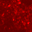
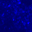
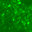
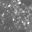
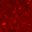
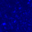
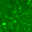
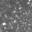

In [30]:
display(HTML(df_HTML.limit(2).toPandas().to_html(escape=False)))

# Writing GeoTiff Images

In [31]:
'''Writing GeoTiff DataFrames as GeoTiff Images'''

df = sedona.read.format("geotiff").option("dropInvalid",True).option("readToCRS", "EPSG:4326").load(DATA_DIR)
df = df.selectExpr("image.origin as origin","ST_GeomFromWkt(image.geometry) as Geom", "image.height as height", "image.width as width", "image.data as data", "image.nBands as bands")

SAVE_PATH = "./data/raster-written/"
df.write.mode("overwrite").format("geotiff").option("writeToCRS", "EPSG:4326").option("fieldGeometry", "Geom").option("fieldNBands", "bands").save(SAVE_PATH)

In [32]:
'''Writing GeoTiff Images in a Single Partition'''
df.coalesce(1).write.mode("overwrite").format("geotiff").option("writeToCRS", "EPSG:4326").option("fieldGeometry", "Geom").option("fieldNBands", "bands").save(SAVE_PATH)

In [33]:
'''Find the Partition of the Written GeoTiff Images.
   If you did not write with coalesce(1), change the below code to adjust the writtenPath'''
writtenPath = SAVE_PATH
dirList = os.listdir(writtenPath)
for item in dirList:
    if os.path.isdir(writtenPath + "/" + item):
        writtenPath += "/" + item
        break

,Geom,RedBand,BlueBand,GreenBand,CombinedBand
0,"POLYGON ((-58.702667236328125 -34.418819427490234, -58.702667236328125 -34.421573638916016, -58.69945526123047 -34.421573638916016, -58.69945526123047 -34.418819427490234, -58.702667236328125 -34.418819427490234))",,,,
1,"POLYGON ((-58.286582946777344 -34.75862503051758, -58.286582946777344 -34.76136779785156, -58.28334426879883 -34.76136779785156, -58.28334426879883 -34.75862503051758, -58.286582946777344 -34.75862503051758))",,,,

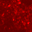
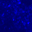
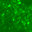
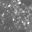
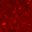
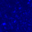
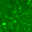
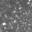

In [35]:
'''Load and Visualize Written GeoTiff Image.'''

df = sedona.read.format("geotiff").option("dropInvalid",True).option("readToCRS", "EPSG:4326").load(writtenPath)
df = df.selectExpr("image.origin as origin","ST_GeomFromWkt(image.geometry) as Geom", "image.height as height", "image.width as width", "image.data as data", "image.nBands as bands")

df = df.selectExpr("RS_GetBand(data,1,bands) as targetband", "height", "width", "bands", "Geom")
df_base64 = df.selectExpr("Geom", "RS_Base64(height,width,RS_Normalize(targetBand), RS_Array(height*width,0.0), RS_Array(height*width, 0.0)) as red","RS_Base64(height,width,RS_Array(height*width, 0.0), RS_Normalize(targetBand), RS_Array(height*width, 0.0)) as green", "RS_Base64(height,width,RS_Array(height*width, 0.0),  RS_Array(height*width, 0.0), RS_Normalize(targetBand)) as blue","RS_Base64(height,width,RS_Normalize(targetBand), RS_Normalize(targetBand),RS_Normalize(targetBand)) as RGB" )
df_HTML = df_base64.selectExpr("Geom","RS_HTML(red) as RedBand","RS_HTML(blue) as BlueBand","RS_HTML(green) as GreenBand", "RS_HTML(RGB) as CombinedBand")
display(HTML(df_HTML.limit(2).toPandas().to_html(escape=False)))

# Transformation of GeoTiff Images

In [37]:
'''First load GeoTiff Images'''
df = sedona.read.format("geotiff").option("dropInvalid",True).option("readToCRS", "EPSG:4326").option("disableErrorInCRS", False).load(DATA_DIR)
df = df.selectExpr("image.origin as origin","ST_GeomFromWkt(image.geometry) as geom", "image.height as height", "image.width as width", "image.data as data", "image.nBands as bands")
df.show(5)

+--------------------+--------------------+------+-----+--------------------+-----+
|              origin|                geom|height|width|                data|bands|
+--------------------+--------------------+------+-----+--------------------+-----+
|file:/Users/niles...|POLYGON ((-58.702...|    32|   32|[1081.0, 1068.0, ...|    4|
|file:/Users/niles...|POLYGON ((-58.286...|    32|   32|[1151.0, 1141.0, ...|    4|
+--------------------+--------------------+------+-----+--------------------+-----+



In [38]:
# First extract the bands for which normalized difference index needs to be calculated
df = df.selectExpr("origin", "geom", "width", "height", "data", "bands", "RS_GetBand(data, 1, bands) as band1", "RS_GetBand(data, 2, bands) as band2")
# Get the normalized difference index between the extracted bands
df = df.selectExpr("origin", "geom", "width", "height", "data", "bands", "RS_NormalizedDifference(band2, band1) as normalizedDifference")
df.show(5)

+--------------------+--------------------+-----+------+--------------------+-----+--------------------+
|              origin|                geom|width|height|                data|bands|normalizedDifference|
+--------------------+--------------------+-----+------+--------------------+-----+--------------------+
|file:/Users/niles...|POLYGON ((-58.702...|   32|    32|[1081.0, 1068.0, ...|    4|[0.09, 0.08, 0.11...|
|file:/Users/niles...|POLYGON ((-58.286...|   32|    32|[1151.0, 1141.0, ...|    4|[0.13, 0.09, 0.09...|
+--------------------+--------------------+-----+------+--------------------+-----+--------------------+



In [39]:
'''RS_Append() takes the data array containing bands, a new band to be appended, and number of total bands in the data array.
    It appends the new band to the end of the data array and returns the appended data'''

df = df.selectExpr("origin", "geom", "RS_Append(data, normalizedDifference, bands) as data_edited", "height", "width", "bands").drop("data")
df = df.withColumn("nBand_edited", col("bands") + 1).drop("bands")
df.show()

+--------------------+--------------------+--------------------+------+-----+------------+
|              origin|                geom|         data_edited|height|width|nBand_edited|
+--------------------+--------------------+--------------------+------+-----+------------+
|file:/Users/niles...|POLYGON ((-58.702...|[1081.0, 1068.0, ...|    32|   32|           5|
|file:/Users/niles...|POLYGON ((-58.286...|[1151.0, 1141.0, ...|    32|   32|           5|
+--------------------+--------------------+--------------------+------+-----+------------+



In [40]:
'''Writing GeoTiff DataFrames as GeoTiff Images'''
SAVE_PATH = "./data/raster-written/"
df.coalesce(1).write.mode("overwrite").format("geotiff").option("writeToCRS", "EPSG:4326").option("fieldGeometry", "geom").option("fieldNBands", "nBand_edited").option("fieldData", "data_edited").save(SAVE_PATH)

# User can also create some UDF manually to manipulate Geotiff dataframes

In [42]:
'''Sample UDF calculates sum of all the values in a band which are greater than 1000.0'''

def SumOfValues(band):
    total = 0.0
    for num in band:
        if num>1000.0:
            total+=1
    return total

df = sedona.read.format("geotiff").option("dropInvalid",True).option("readToCRS", "EPSG:4326").load(DATA_DIR)
df = df.selectExpr("image.origin as origin","ST_GeomFromWkt(image.geometry) as Geom", "image.height as height", "image.width as width", "image.data as data", "image.nBands as bands")
df = df.selectExpr("RS_GetBand(data,1,bands) as targetband", "height", "width", "bands", "Geom")
    
calculateSum = udf(SumOfValues, DoubleType())
sedona.udf.register("RS_Sum", calculateSum)

sumDF = df.selectExpr("RS_Sum(targetband) as sum")
sumDF.show()

+------+
|   sum|
+------+
| 753.0|
|1017.0|
+------+



,Geom,selectedregion
0,"POLYGON ((-58.70271939504447 -34.418775445554786, -58.702776058228636 -34.421569880680615, -58.6994039180242 -34.42161679331493, -58.69934736692278 -34.4188223533111, -58.70271939504447 -34.418775445554786))",
1,"POLYGON ((-58.286636576261145 -34.758580906202866, -58.286679941749476 -34.76137571668496, -58.28329340123003 -34.76141146033393, -58.28325014980317 -34.75861664615162, -58.286636576261145 -34.758580906202866))",

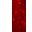
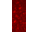

In [43]:
'''Sample UDF to visualize a particular region of a GeoTiff image'''

def generatemask(band, width,height):
    for (i,val) in enumerate(band):
        if (i%width>=12 and i%width<26) and (i%height>=12 and i%height<26):
            band[i] = 255.0
        else:
            band[i] = 0.0
    return band

maskValues = udf(generatemask, ArrayType(DoubleType()))
sedona.udf.register("RS_MaskValues", maskValues)


df_base64 = df.selectExpr("Geom", "RS_Base64(height,width,RS_Normalize(targetband), RS_Array(height*width,0.0), RS_Array(height*width, 0.0), RS_MaskValues(targetband,width,height)) as region" )
df_HTML = df_base64.selectExpr("Geom","RS_HTML(region) as selectedregion")
display(HTML(df_HTML.limit(2).toPandas().to_html(escape=False)))
